# Siemens Logistic - Data Exploration - Tracking Status

This google colab instance was written with the goal to establish a versitile and light-weight model for the prediction of delivery date of shipements.

# Data Import & Preperation

## Data Import

In [ ]:
"load and parse the raw data"

# Imports
# Create_Flat_Tracking
import pandas as pd
import numpy as np
import os
import json
import glob
from tqdm import tqdm_notebook

def replace_name(column_name):
    start_index = column_name.find("_source.")
    if start_index != -1:
        return column_name[len("_source")+1:]
    else:
        return column_name

# Mount my Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Temp Dataframe
df_tracking = pd.DataFrame()

# Read JSON in Folder
# TODO: Make a better parrallel implementation
print("\n# Importing files from Google drive")
path_to_read = '/content/drive/MyDrive/Colab_Notebooks/Data/tracking_status/*'
file_list = glob.glob(path_to_read)
for file in tqdm_notebook(file_list,desc="Importing Source File"):  
  _file = open(file, encoding='utf8')
  data = json.load(_file)
  df_tracking = df_tracking.append(pd.json_normalize(data), ignore_index = True)

df_tracking.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

# Importing files from Google drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/content/drive/MyDrive/Colab_Notebooks/Data/tracking_status/f95466c6-61c7-4025-9867-36aeef74e3cc
/content/drive/MyDrive/Colab_Notebooks/Data/tracking_status/38edfd28-9550-4a4b-aba2-9516026f9796
/content/drive/MyDrive/Colab_Notebooks/Data/tracking_status/743efc0f-aa92-40a6-a245-ca287d364c00
/content/drive/MyDrive/Colab_Notebooks/Data/tracking_status/12b49845-817d-4d6e-9104-ddb3613464e9



,_index,_type,_id,_score,_source.LOCATION,_source.reason_DE,_source.END_DATE,_source.START_DATE,_source.STATUS_DATE,_source.status_EN,_source.EXPLANATION,_source.SYSTEM_DATE,_source.OBJECT_ID,_source.status_DE,_source.SHIPMENTID,_source.TS_ID,_source.reason_EN
0,s5740_heppner_trackingstatuses,_doc,-154296816,1.0,EDI,Ablieferbeleg (POD) archiviert (FR),18-02-2020 05:00:00,11-02-2020 05:00:00,2020-02-11 23:59:00.0,archived,,2020-02-12 06:23:37.0,-154296816,Archiviert,339862785,2657203636,POD archived
1,s5740_heppner_trackingstatuses,_doc,-404782954,1.0,EDI,Reine Quittung,18-02-2020 05:00:00,11-02-2020 05:00:00,2020-02-12 16:30:00.0,Delivered,,2020-02-12 17:23:18.0,-404782954,Zugestellt,339862790,2658452908,clean P.O.D.
2,s5740_heppner_trackingstatuses,_doc,2127211062,1.0,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,18-02-2020 05:00:00,11-02-2020 05:00:00,2020-02-11 09:14:00.0,delivery,,2020-02-11 09:56:35.0,2127211062,Zustellung,339862792,2655206674,En route to consignee
3,s5740_heppner_trackingstatuses,_doc,-1450460073,1.0,EDI,Ablieferbeleg (POD) archiviert (FR),18-02-2020 05:00:00,11-02-2020 05:00:00,2020-02-13 23:59:00.0,archived,,2020-02-14 06:23:26.0,-1450460073,Archiviert,339862799,2662154905,POD archived
4,s5740_heppner_trackingstatuses,_doc,996178111,1.0,EDI,Reine Quittung,18-02-2020 05:00:00,11-02-2020 05:00:00,2020-02-12 19:47:00.0,Delivered,,2020-02-12 20:26:05.0,996178111,Zugestellt,339862813,2658791136,clean P.O.D.


## Format Data & Columns

In [ ]:
# Rename and format columns
# Rename column
df_tracking = df_tracking.rename(columns={c: replace_name(c.strip()) for c in df_tracking.columns})
df_tracking = df_tracking.drop(df_tracking.columns[df_tracking.columns.str.startswith('_')], axis=1)
#Apply datatype
df_tracking[[c for c in df_tracking.columns if not c.endswith('_DATE')]] = \
    df_tracking[[c for c in df_tracking.columns if not c.endswith('_DATE')]].astype(pd.StringDtype())
df_tracking[[c for c in df_tracking.columns if c.endswith('_DATE')]] = \
    df_tracking[[c for c in df_tracking.columns if  c.endswith('_DATE')]].apply(pd.to_datetime)
df_tracking.head()

# Groups and remove duplicates
# Remove duplicate
df_tracking_no_duplicate =   df_tracking.drop_duplicates(['SHIPMENTID', 'reason_DE', 'status_DE'])
# Filter uniques and groups
uniques = df_tracking_no_duplicate['reason_DE'].unique()
df_tracking_no_duplicate_sorted = df_tracking_no_duplicate.sort_values(['STATUS_DATE'])
df_tracking_no_duplicate_sorted

,LOCATION,reason_DE,END_DATE,START_DATE,STATUS_DATE,status_EN,EXPLANATION,SYSTEM_DATE,OBJECT_ID,status_DE,SHIPMENTID,TS_ID,reason_EN
17561,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 00:00:00,delivery,,2019-01-02 11:23:10,533190740,Zustellung,297586898,2006288578,En route to consignee
477012,EDI,Eingang Versandpartner,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 15:45:00,discharge,NEU-ULM 5082,2019-01-02 16:23:13,1635777866,Entladung,297975316,2006558392,Inbound Sending Partner
17523,EDI,Reine Quittung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 23:58:00,Delivered,,2019-01-03 06:23:13,461433342,Zugestellt,297586898,2007443459,clean P.O.D.
477051,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 00:00:00,delivery,,2019-01-03 13:53:18,-542459960,Zustellung,297166330,2008041575,En route to consignee
17520,EDI,Ablieferbeleg (POD) archiviert (FR),2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 23:59:00,archived,,2019-01-04 06:23:13,939202209,Archiviert,297166330,2009312473,POD archived
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832126,EDI,Eingang Empfangspartner,2020-10-28 05:00:00,2020-10-27 05:00:00,2020-10-27 20:45:00,discharge,STRASBOURG,2020-10-27 20:59:23,239812326,Entladung,370417607,3113609099,Inbound Receiving Partner
1822232,EDI,Eingang Empfangspartner,2020-10-28 05:00:00,2020-10-27 05:00:00,2020-10-27 20:45:00,discharge,STRASBOURG,2020-10-27 20:59:23,339354950,Entladung,370417687,3113609107,Inbound Receiving Partner
454302,EDI,Eingang Empfangspartner,2020-10-28 05:00:00,2020-10-27 05:00:00,2020-10-27 20:45:00,discharge,STRASBOURG,2020-10-27 20:59:22,1340132365,Entladung,370408428,3113609065,Inbound Receiving Partner
454300,EDI,Eingang Empfangspartner,2020-10-28 05:00:00,2020-10-27 05:00:00,2020-10-27 20:45:00,discharge,STRASBOURG,2020-10-27 20:59:24,-1222786374,Entladung,370482549,3113609134,Inbound Receiving Partner


## Map to Milestones

In [ ]:
# Compute milesstones
# Milesstines to Events mapping 
# TODO: Incomplete
milestone_to_event = {
    300:{
        "name": "Abholung",
        "event_list": ['Sendung abgeholt / Eingang Lager VP', 
                     'Abholung geplant am', 
                     'Sendung an Drittpartner verladen',
                     'Sendung abgeholt',
                     'Sendung verladen', 
                     'Sdg. noch nicht versandfertig',
                     'Kunde wünscht Terminabstimmung', 
                     'niemand angetroffen', 
                     'Sdg. nicht erhalten', 
                     'Zusatztext']
    },
    400:{
        "name": "Ankunft in Abholterminal",
         "event_list": ['Eingang Empfangspartner']
    },
    410:{
        "name": "Abfahrt von Abholterminal",
         "event_list": ['Verladen an', 
                     'Verladen in Produktionsgebiet an',
                     'Verladung an/durch Fremdspediteur']
    },
    490:{
        "name": "Ankunft Zustellterminal",
         "event_list": ['Eingang Versandpartner']
    },
}
# Event-to-milestones Mapping
event_to_milestones = {
          'Sendung abgeholt / Eingang Lager VP':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Abholung geplant am':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Sendung an Drittpartner verladen':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Sendung abgeholt':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Sendung verladen':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Eingang Empfangspartner':{
              "milestone_name": "Ankunft in Abholterminal",
              "milestone_value": 400,
          },
                     'Verladen an':{
              "milestone_name": "Abfahrt von Abholterminal",
              "milestone_value": 410,
          },
                     'Verladen in Produktionsgebiet an':{
              "milestone_name": "Abfahrt von Abholterminal",
              "milestone_value": 410,
          },
                     'Verladung an/durch Fremdspediteur':{
              "milestone_name": "Abfahrt von Abholterminal",
              "milestone_value": 410,
          },
                     'Eingang Versandpartner':{
              "milestone_name": "Ankunft Zustellterminal",
              "milestone_value": 490,
          },
                     'Sendung auf dem Weg zum Empfänger/in Zustellung':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Sendung für Zustellung vorgesehen/Nachladesendung':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Reine Quittung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Zustellung nicht belegbar/Wechselbrückengestellung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'mit Beschädigung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'mit Teilfehlmenge':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Teil-Annahmeverweigert':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Ablieferbeleg (POD) archiviert (FR)':{
              "milestone_name": "Archiviert",
              "milestone_value": 650,
          },
                     'Ablieferbeleg (POD) archiviert (DE)':{
              "milestone_name": "Archiviert",
              "milestone_value": 650,
          },
                     'Zustellbeleg (POD) archiviert':{
              "milestone_name": "Archiviert",
              "milestone_value": 650,
          },
                     'Digitalfoto archiviert':{
              "milestone_name": "Archiviert",
              "milestone_value": 650,
          },
                     'Sdg. noch nicht versandfertig':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Kunde wünscht Terminabstimmung':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'niemand angetroffen':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Sdg. nicht erhalten':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Zusatztext':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'keine Warenannahme oder Vereinbarung':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Zustellung muss mit Empfänger abgestimmt werden':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Ereignis zu Lasten EP':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Sendung fehlt komplett lt. EB':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Sendung unvollständig':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Komplett-Fehlmenge per EB gemeldet':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'keine Warenannahme oder geschlossen':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Annahmeverweigert/Unzustellbar':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Annahmeverweigerte Sendung - Retour lt. Verfügung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Zeitmangel auf Zustelltour':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Empfänger nicht angetroffen':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Ware beschädigt':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'nicht bestellt':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Lieferschein fehlt/Begleitpapiere unvollständig':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Fehlmenge':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Liefertermin überschritten':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          } ,
          'Empfänger ist Selbstabholer':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          } ,
                     'Sdg. noch nicht versandfertig':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
          'Erledigung durch …':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Zusatztext':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Zeitmangel':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Platzmangel':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Platzmangel auf Zustelltour':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
          'Voraussichtliche Zustellung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'LKW von VP verspätet':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
          'Sendung verstapelt/nicht auffindbar':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
          # 'Avisvorschrift lt. DFÜ/Beleg/Anweisung',
                     'Unvollständige/Falsche Sendungsangaben':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Annahmeverweigerte Sendung - keine Retourverfügung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'Zu lange Wartezeit beim Empfänger':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'höhere Gewalt':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
          # 'Fix- oder Zustelltermin lt. Vorgabe'
                     'Empfänger zahlt Warenwertnachnahme/EUST nicht':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
          #'Avis wegen Inkasso'
          #'Avisvereinbarung mit Empfänger'
          #'Hebebühne erforderlich'
                     'Sendung endgültig in Verlust':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Originalpapiere fehlen':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Aufrag/Bestellung unbekannt':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'regionaler Feiertag':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'nicht transportsicher verpackt':{
              "milestone_name": "In Zustellung",
              "milestone_value": 500,
          },
                     'Adressfehler':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'außerhalb der Betriebszeiten':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
                     'mit Teilfehlmenge und Beschädigung':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          },
          #'Zollgut'
                     'Sdg. Von anderem Sped. Übernommen':{
              "milestone_name": "Abholung",
              "milestone_value": 300,
          },
                     'Zustellung nicht belegbar/Zustellbeleg verloren':{
              "milestone_name": "Archiviert",
              "milestone_value": 650,
          },
                     'Empfänger außerhalb Produktionsgebiet':{
              "milestone_name": "Zustellung",
              "milestone_value": 600,
          }                
}

def mapEventlabelToMilestonesValue(data_input):
  if not event_to_milestones.get(data_input) is None:
    return event_to_milestones[data_input]["milestone_value"]
  else:
    return 999

def mapEventlabelToMilestonesName(data_input):
  if not event_to_milestones.get(data_input) is None:
    return event_to_milestones[data_input]["milestone_name"]
  else:
    return "-"

df_tracking_no_duplicate_sorted["MILESTONES"] = df_tracking_no_duplicate_sorted["reason_DE"].apply(mapEventlabelToMilestonesName)
df_tracking_no_duplicate_sorted["REIHENFOLGE"] = df_tracking_no_duplicate_sorted["reason_DE"].apply(mapEventlabelToMilestonesValue).astype('int32')
df_tracking_no_duplicate_sorted.head(5)


,LOCATION,reason_DE,END_DATE,START_DATE,STATUS_DATE,status_EN,EXPLANATION,SYSTEM_DATE,OBJECT_ID,status_DE,SHIPMENTID,TS_ID,reason_EN,MILESTONES,REIHENFOLGE
17561,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 00:00:00,delivery,,2019-01-02 11:23:10,533190740,Zustellung,297586898,2006288578,En route to consignee,In Zustellung,500
477012,EDI,Eingang Versandpartner,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 15:45:00,discharge,NEU-ULM 5082,2019-01-02 16:23:13,1635777866,Entladung,297975316,2006558392,Inbound Sending Partner,Ankunft Zustellterminal,490
17523,EDI,Reine Quittung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 23:58:00,Delivered,,2019-01-03 06:23:13,461433342,Zugestellt,297586898,2007443459,clean P.O.D.,Zustellung,600
477051,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 00:00:00,delivery,,2019-01-03 13:53:18,-542459960,Zustellung,297166330,2008041575,En route to consignee,In Zustellung,500
17520,EDI,Ablieferbeleg (POD) archiviert (FR),2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 23:59:00,archived,,2019-01-04 06:23:13,939202209,Archiviert,297166330,2009312473,POD archived,Archiviert,650


# Data Preprocessing

## Extract Shortened Datasets

In [ ]:
# Select only relevant Data
df_tracking_short = df_tracking_no_duplicate_sorted[['SHIPMENTID', 'reason_DE', 'STATUS_DATE', 'SYSTEM_DATE','MILESTONES','REIHENFOLGE']]
df_unique_shipments = df_tracking_no_duplicate_sorted['SHIPMENTID'].unique()

# Select data with no milestones allocation
df_no_milestones = df_tracking_short[df_tracking_short['MILESTONES'] == '-']
df_unique_shipment_with_no_milestones = df_no_milestones['SHIPMENTID'].unique()

# Remove Data with valid milestones
df_valid_milestones = df_tracking_short[df_tracking_short['MILESTONES'] != '-']
df_unique_shipment_with_valid_milestones = df_valid_milestones['SHIPMENTID'].unique()

# Select Data with milestone "Zustellung" or archiviert
df_events_with_zugeliefert = df_tracking_no_duplicate_sorted[df_tracking_no_duplicate_sorted['REIHENFOLGE'] >= 600]
df_uniques_shipments_zugeliefert = df_events_with_zugeliefert['SHIPMENTID'].unique()

# Select Shipments with that are not delivered yet
df_events_abgeholt = df_tracking_no_duplicate_sorted[df_tracking_no_duplicate_sorted['REIHENFOLGE'] >= 300]
df_uniques_shipments_abgeholt = df_events_abgeholt['SHIPMENTID'].unique()
# df_uniques_shipments_not_delivered = [ele for ele in df_uniques_shipments_abgeholt if ele not in df_uniques_shipments_zugeliefert]
# df_uniques_shipments_not_delivered
# df_uniques_shipments_not_delivered




## Compute Duration of Shipments based On Events received

In [ ]:
# Compute Metric for each delivery
# Compute Shipment Total Durattion based on received events
SHIPMENT_FIRST_EVENT_DATE = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID'], sort=False)["STATUS_DATE"].min()
SHIPMENT_LAST_EVENT_DATE = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID'], sort=False)["STATUS_DATE"].max()
SHIPMENT_DURATION_BY_EVENTS = SHIPMENT_LAST_EVENT_DATE- SHIPMENT_FIRST_EVENT_DATE
SHIPMENT_DURATION_BY_EVENTS = SHIPMENT_DURATION_BY_EVENTS.reset_index().rename(columns={"STATUS_DATE": "DURATION"})

## Compute Milestone Time Properties

In [ ]:
!pip install -U tornado
!pip install "dask[complete]"

     |████████████████████████████████| 430kB 4.3MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1


     |████████████████████████████████| 675kB 6.3MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=127e73dc0a6776a92a75c0c0d1f32f23edf4d13079c7006c58281768fe0b551e
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=c9e3c9a91c7c1233ec2dd52fc19ed5b409f97394a2bc877d5299ff17795be804
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built locket contextvars
ERROR: distributed 2020.12.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2020.12.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distrib

In [ ]:
# Compute The corresponding milestone Start time as the status time of the first event corresponding to this milestone
df_tracking_no_duplicate_sorted["MILESTONES_START_DATE"] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["STATUS_DATE"].transform('min')
df_tracking_no_duplicate_sorted["MILESTONES_EVENT_COUNT"] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["reason_DE"].transform('count')

# Compute the milestones End Time
# First consider it to be the status time of the last event corresponding to the this milestone and shipment
df_tracking_no_duplicate_sorted["MILESTONES_END_DATE_tmp"] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["STATUS_DATE"].transform('max')


In [ ]:
# Then update it with the status date of the first event of the next milestone. Beacuse only there we are sure that the next milestone have startet
# Comppute
SHIPMENT_BY_MILESTONES = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["reason_DE"].agg(['count'])
SHIPMENT_BY_MILESTONES["Last_Event_Date"] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["STATUS_DATE"].agg(['max'])
SHIPMENT_BY_MILESTONES["First_Event_Date"] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], sort=False)["STATUS_DATE"].agg(['min'])
#SHIPMENT_BY_MILESTONES["Time_in_Milestone"] = SHIPMENT_BY_MILESTONES["Last_Event_Date"] - SHIPMENT_BY_MILESTONES["First_Event_Date"]
#df_tracking_no_duplicate_sorted['SHIPMENT_FIRST_EVENT_DATE'] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID'], sort=False)["STATUS_DATE"].transform(min)
#df_tracking_no_duplicate_sorted['SHIPMENT_LAST_EVENT_DATE'] = df_tracking_no_duplicate_sorted.groupby(['SHIPMENTID'], sort=False)["STATUS_DATE"].transform(max)
#df_tracking_no_duplicate_sorted['SHIPMENT_DURATION_BY_EVENTS'] = df_tracking_no_duplicate_sorted['SHIPMENT_LAST_EVENT_DATE'] - df_tracking_no_duplicate_sorted['SHIPMENT_FIRST_EVENT_DATE']
SHIPMENT_BY_MILESTONES = SHIPMENT_BY_MILESTONES.reset_index()

In [ ]:
SHIPMENT_BY_MILESTONES

,SHIPMENTID,MILESTONES,REIHENFOLGE,count,Last_Event_Date,First_Event_Date
0,297586898,In Zustellung,500,1,2019-01-02 00:00:00,2019-01-02 00:00:00
1,297975316,Ankunft Zustellterminal,490,1,2019-01-02 15:45:00,2019-01-02 15:45:00
2,297586898,Zustellung,600,1,2019-01-02 23:58:00,2019-01-02 23:58:00
3,297166330,In Zustellung,500,1,2019-01-03 00:00:00,2019-01-03 00:00:00
4,297166330,Archiviert,650,1,2019-01-03 23:59:00,2019-01-03 23:59:00
...,...,...,...,...,...,...
1147112,370417607,Ankunft in Abholterminal,400,1,2020-10-27 20:45:00,2020-10-27 20:45:00
1147113,370417687,Ankunft in Abholterminal,400,1,2020-10-27 20:45:00,2020-10-27 20:45:00
1147114,370408428,Ankunft in Abholterminal,400,1,2020-10-27 20:45:00,2020-10-27 20:45:00
1147115,370482549,Ankunft in Abholterminal,400,1,2020-10-27 20:45:00,2020-10-27 20:45:00


## Not Finish !!!!! TODO: Jupiter

### Process it in parrallel with DASK

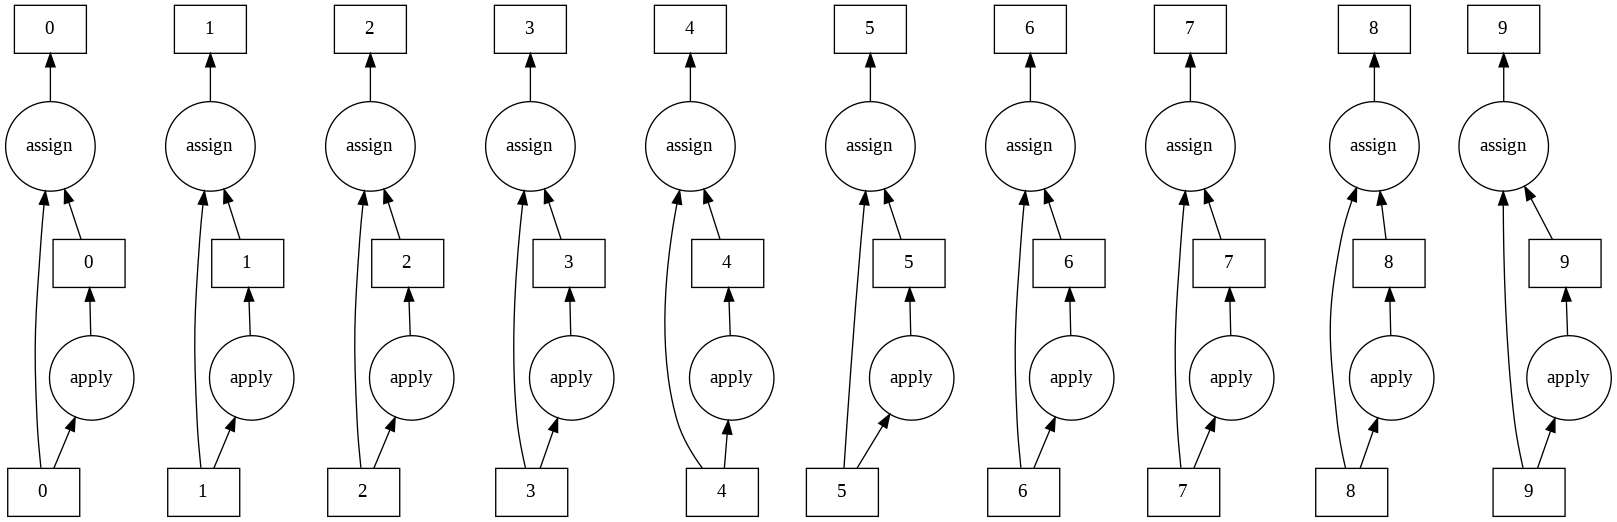

In [ ]:
# DASK Parralelization
# Compute next milestone start of each events
import dask as dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

df_test = df_tracking_no_duplicate_sorted.head(1000)
ddf_test = dd.from_pandas(df_test, npartitions=10)
dSHIPMENT_BY_MILESTONES = dd.from_pandas(SHIPMENT_BY_MILESTONES, npartitions=1)

def mapping(data_input):
  _reihenfolge = data_input['REIHENFOLGE']
  _shipmentId = data_input['SHIPMENTID']
  tmp = SHIPMENT_BY_MILESTONES[(SHIPMENT_BY_MILESTONES['SHIPMENTID'] == _shipmentId) & (SHIPMENT_BY_MILESTONES['REIHENFOLGE'] > _reihenfolge)]["First_Event_Date"].min()
  if tmp is pd.NaT:
    return data_input['MILESTONES_END_DATE_tmp']
  else:
    return tmp

ddf_test['MILESTONES_END_DATE'] = ddf_test.apply(mapping, axis = 1,meta=('MILESTONES_END_DATE', 'datetime64[ns]'))
ddf_test.visualize()

In [ ]:
from multiprocessing.pool import ThreadPool
with dask.config.set(pool=ThreadPool(10)):
  ddf_test.compute(num_workers=10)

[                                        ] | 0% Completed |  1min 57.2s
[                                        ] | 0% Completed |  1min 58.7s


KeyboardInterrupt: ignored

In [ ]:
pbar.unregister()
# client.close()

KeyError: ignored

### Process it normally using PD.Apply

In [ ]:
# PROBLEMATISH - JUPITER
# Compute next milestone start of each events
import dask.dataframe as dd

from tqdm.autonotebook import tqdm
df_test = df_tracking_no_duplicate_sorted.head(1000)

tqdm.pandas(desc="Computing Real Milestones Enddate")

def mapping(data_input):
  _reihenfolge = data_input['REIHENFOLGE']
  _shipmentId = data_input['SHIPMENTID']
  tmp = SHIPMENT_BY_MILESTONES[(SHIPMENT_BY_MILESTONES['SHIPMENTID'] == _shipmentId) & (SHIPMENT_BY_MILESTONES['REIHENFOLGE'] > _reihenfolge)]["First_Event_Date"].min()
  if tmp is pd.NaT:
    return data_input['MILESTONES_END_DATE_tmp']
  else:
    return tmp
    
df_test['MILESTONES_END_DATE'] = df_test.progress_apply(mapping, axis = 1)

# Clean Up everything
df_test = df_test.drop(columns=['MILESTONES_END_DATE_tmp'])

# Start with 300 
df_test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LOCATION,reason_DE,END_DATE,START_DATE,STATUS_DATE,status_EN,EXPLANATION,SYSTEM_DATE,OBJECT_ID,status_DE,SHIPMENTID,TS_ID,reason_EN,MILESTONES,REIHENFOLGE,MILESTONES_START_DATE,MILESTONES_EVENT_COUNT,MILESTONES_END_DATE
17561,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 00:00:00,delivery,,2019-01-02 11:23:10,533190740,Zustellung,297586898,2006288578,En route to consignee,In Zustellung,500,2019-01-02 00:00:00,1,2019-01-02 23:58:00
477012,EDI,Eingang Versandpartner,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 15:45:00,discharge,NEU-ULM 5082,2019-01-02 16:23:13,1635777866,Entladung,297975316,2006558392,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-01-02 15:45:00,1,2019-01-11 21:13:00
17523,EDI,Reine Quittung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 23:58:00,Delivered,,2019-01-03 06:23:13,461433342,Zugestellt,297586898,2007443459,clean P.O.D.,Zustellung,600,2019-01-02 23:58:00,1,2019-01-02 23:58:00
477051,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 00:00:00,delivery,,2019-01-03 13:53:18,-542459960,Zustellung,297166330,2008041575,En route to consignee,In Zustellung,500,2019-01-03 00:00:00,1,2019-01-03 23:59:00
17520,EDI,Ablieferbeleg (POD) archiviert (FR),2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 23:59:00,archived,,2019-01-04 06:23:13,939202209,Archiviert,297166330,2009312473,POD archived,Archiviert,650,2019-01-03 23:59:00,1,2019-01-03 23:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096687,EDI,Eingang Versandpartner,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:49:00,discharge,KORNWESTHEIM 5076,2019-02-15 15:23:20,-1553073556,Entladung,303275263,2092764794,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-02-15 14:49:00,1,2019-02-19 08:10:00
180763,EDI,Eingang Versandpartner,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:50:00,discharge,FRANKFURT 5068,2019-02-18 15:53:20,-1584809771,Entladung,303448958,2096455258,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-02-15 14:50:00,1,2019-02-18 00:00:00
3521,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:51:00,delivery,,2019-02-15 15:23:21,1346111800,Zustellung,303275279,2092764818,En route to consignee,In Zustellung,500,2019-02-15 14:51:00,1,2019-02-18 10:26:00
66268,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:51:00,delivery,,2019-02-15 15:23:20,-532155868,Zustellung,303275267,2092764797,En route to consignee,In Zustellung,500,2019-02-15 14:51:00,1,2019-02-18 10:26:00


### Process using PD.Join

In [ ]:
# PROBLEMATISH - JUPITER
# Compute next milestone start of each events
import dask.dataframe as dd

from tqdm.autonotebook import tqdm
df_test = df_tracking_no_duplicate_sorted.head(1000)
df_test_left = SHIPMENT_BY_MILESTONES[['SHIPMENTID', 'First_Event_Date']]

tqdm.pandas(desc='Processing')

df_test_2 = pd.merge(df_test, SHIPMENT_BY_MILESTONES, left_on=['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'], right_on=['SHIPMENTID', 'MILESTONES', 'REIHENFOLGE'])
df_test_2

,LOCATION,reason_DE,END_DATE,START_DATE,STATUS_DATE,status_EN,EXPLANATION,SYSTEM_DATE,OBJECT_ID,status_DE,SHIPMENTID,TS_ID,reason_EN,MILESTONES,REIHENFOLGE,MILESTONES_START_DATE,MILESTONES_EVENT_COUNT,MILESTONES_END_DATE_tmp,count,Last_Event_Date,First_Event_Date
0,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 00:00:00,delivery,,2019-01-02 11:23:10,533190740,Zustellung,297586898,2006288578,En route to consignee,In Zustellung,500,2019-01-02 00:00:00,1,2019-01-02 00:00:00,1,2019-01-02 00:00:00,2019-01-02 00:00:00
1,EDI,Eingang Versandpartner,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 15:45:00,discharge,NEU-ULM 5082,2019-01-02 16:23:13,1635777866,Entladung,297975316,2006558392,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-01-02 15:45:00,1,2019-01-02 15:45:00,1,2019-01-02 15:45:00,2019-01-02 15:45:00
2,EDI,Reine Quittung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-02 23:58:00,Delivered,,2019-01-03 06:23:13,461433342,Zugestellt,297586898,2007443459,clean P.O.D.,Zustellung,600,2019-01-02 23:58:00,1,2019-01-02 23:58:00,1,2019-01-02 23:58:00,2019-01-02 23:58:00
3,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 00:00:00,delivery,,2019-01-03 13:53:18,-542459960,Zustellung,297166330,2008041575,En route to consignee,In Zustellung,500,2019-01-03 00:00:00,1,2019-01-03 00:00:00,1,2019-01-03 00:00:00,2019-01-03 00:00:00
4,EDI,Ablieferbeleg (POD) archiviert (FR),2019-08-01 05:00:00,2019-01-01 05:00:00,2019-01-03 23:59:00,archived,,2019-01-04 06:23:13,939202209,Archiviert,297166330,2009312473,POD archived,Archiviert,650,2019-01-03 23:59:00,1,2019-01-03 23:59:00,1,2019-01-03 23:59:00,2019-01-03 23:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,EDI,Eingang Versandpartner,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:49:00,discharge,KORNWESTHEIM 5076,2019-02-15 15:23:20,-1553073556,Entladung,303275263,2092764794,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-02-15 14:49:00,1,2019-02-15 14:49:00,1,2019-02-15 14:49:00,2019-02-15 14:49:00
996,EDI,Eingang Versandpartner,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:50:00,discharge,FRANKFURT 5068,2019-02-18 15:53:20,-1584809771,Entladung,303448958,2096455258,Inbound Sending Partner,Ankunft Zustellterminal,490,2019-02-15 14:50:00,1,2019-02-15 14:50:00,1,2019-02-15 14:50:00,2019-02-15 14:50:00
997,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:51:00,delivery,,2019-02-15 15:23:21,1346111800,Zustellung,303275279,2092764818,En route to consignee,In Zustellung,500,2019-02-15 14:51:00,1,2019-02-15 14:51:00,1,2019-02-15 14:51:00,2019-02-15 14:51:00
998,EDI,Sendung auf dem Weg zum Empfänger/in Zustellung,2019-02-19 05:00:00,2019-12-02 05:00:00,2019-02-15 14:51:00,delivery,,2019-02-15 15:23:20,-532155868,Zustellung,303275267,2092764797,En route to consignee,In Zustellung,500,2019-02-15 14:51:00,1,2019-02-15 14:51:00,1,2019-02-15 14:51:00,2019-02-15 14:51:00


# Statistics

In [ ]:
print("## Total Number of events/records: ", len(df_tracking.index))
print("## Total Number of distincts events/records: ", len(df_tracking_no_duplicate_sorted.index))
print("## Total Number of events assigned to a milestone : ", len(df_valid_milestones.index))
print("## Total Number of events with no milestone assignements: ", len(df_no_milestones.index))

print("## Total Number of shipments: ", len(df_unique_shipments))
print("## Total Number of shipments with an event assigned to a milestone : ", len(df_unique_shipment_with_valid_milestones))
print("## Total Number of shipment with an event with no milestone assignements: ", len(df_unique_shipment_with_no_milestones))

print("## Total Number of shipments: ", len(df_unique_shipments))
print("## Total Number of shipments that habe been picked-up: ", len(df_uniques_shipments_abgeholt))
print("## Total Number of shipments delivered or archived: ", len(df_uniques_shipments_zugeliefert))
print("## Total Number of shipment that are not delivered yet: ", len(df_uniques_shipments_abgeholt) - len(df_uniques_shipments_zugeliefert), " which is ", (((len(df_uniques_shipments_abgeholt) - len(df_uniques_shipments_zugeliefert))/(len(df_uniques_shipments_abgeholt))) * 100), "%")


NameError: ignored

# Visualisation

### Event Distribution

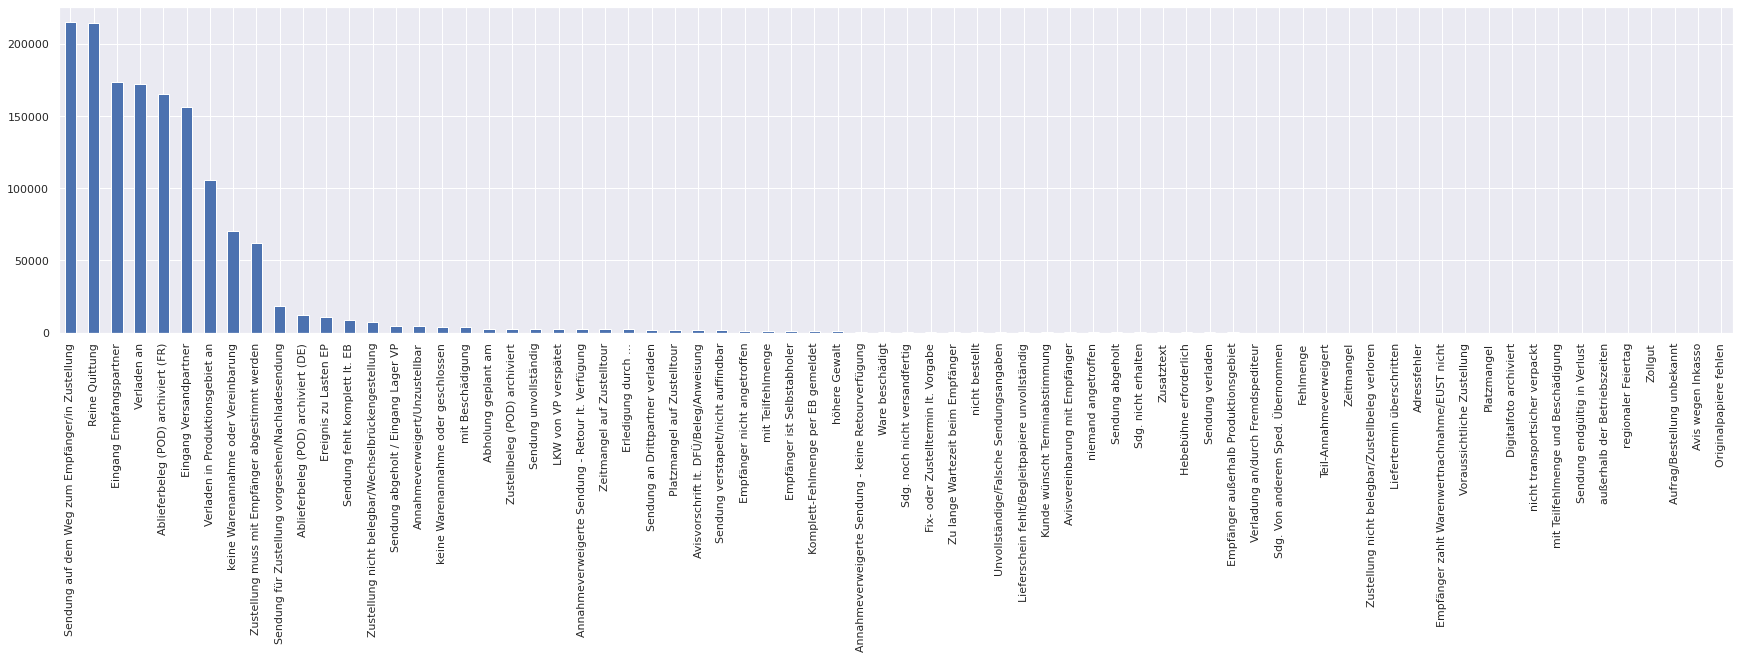

In [ ]:
# Visualize frequency of events
import matplotlib.pyplot as plt
from matplotlib import colors

plt.figure(figsize=(30,6))
df_tracking_no_duplicate_sorted['reason_DE'].value_counts().plot(kind='bar')
plt.show()

### Events by Milestones

#### Number of events with corresponding Milestones: 1447887


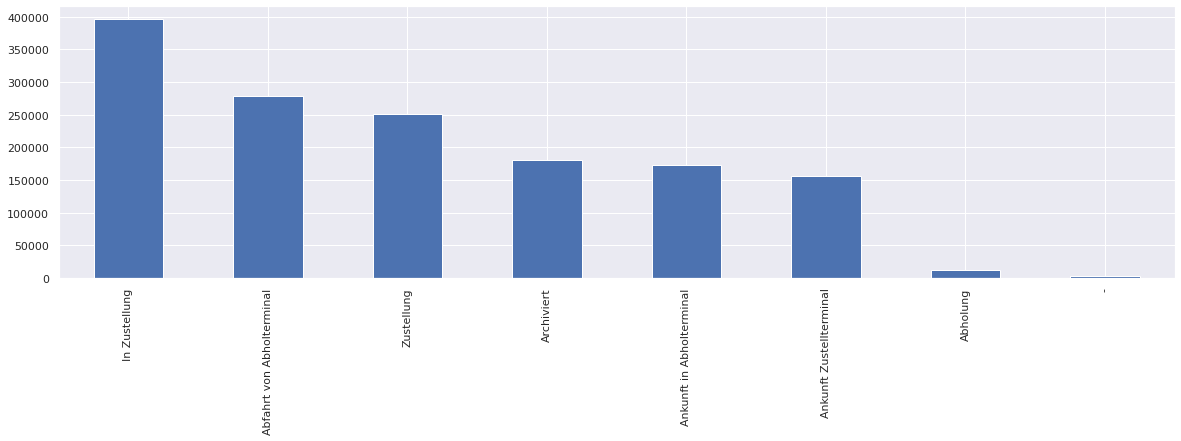


#### Counts of events
In Zustellung                396008
Abfahrt von Abholterminal    277815
Zustellung                   250294
Archiviert                   180236
Ankunft in Abholterminal     173299
Ankunft Zustellterminal      156107
Abholung                      11648
-                              2480
Name: MILESTONES, dtype: int64

#### Histogram of milestones


In [ ]:
# Visualize frequency of milesstones
import matplotlib.pyplot as plt
from matplotlib import colors

plt.figure(figsize=(20,5))
df_tracking_no_duplicate_sorted['MILESTONES'].value_counts().plot(kind='bar')
print("#### Number of events with corresponding Milestones: {}".format(len(df_tracking_no_duplicate_sorted['MILESTONES'].index)))
plt.show()

print("\n#### Counts of events")
print(df_tracking_no_duplicate_sorted['MILESTONES'].value_counts())
print("\n#### Histogram of milestones")

### Events with No Milestones

#### Number of events with no corresponding Milestones: 2480

#### Counts of events
Avisvorschrift lt. DFÜ/Beleg/Anweisung    1513
Fix- oder Zustelltermin lt. Vorgabe        459
Avisvereinbarung mit Empfänger             325
Hebebühne erforderlich                     180
Zollgut                                      2
Avis wegen Inkasso                           1
Name: reason_DE, dtype: Int64

#### Histogram of events


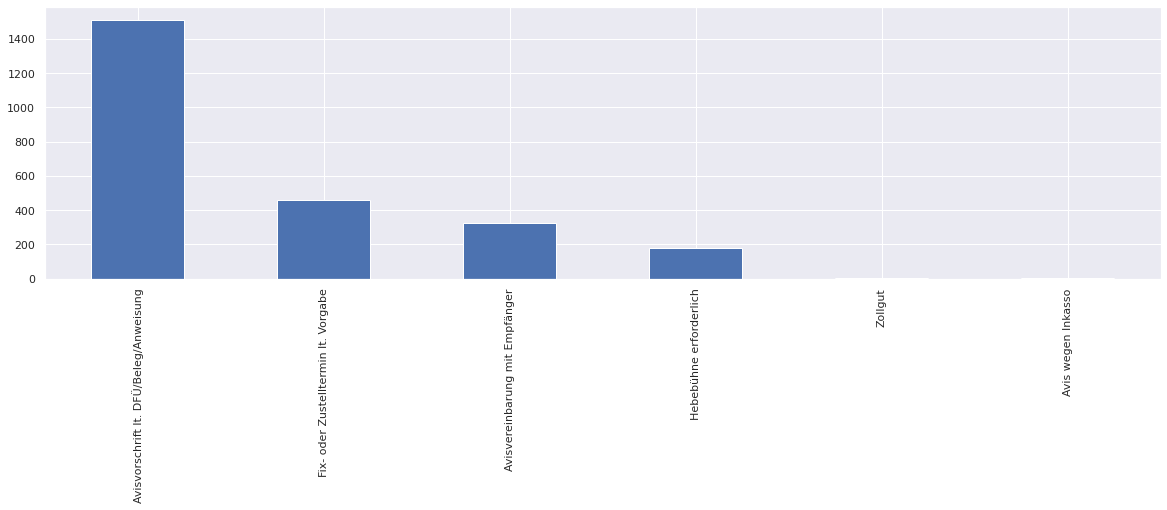

In [ ]:
# Print statistic of events without milestones
import matplotlib.pyplot as plt
from matplotlib import colors

print("#### Number of events with no corresponding Milestones: {}".format(len(df_no_milestones.index)))
print("\n#### Counts of events")
print(df_no_milestones['reason_DE'].value_counts())
print("\n#### Histogram of events")
plt.figure(figsize=(20,5))
df_no_milestones['reason_DE'].value_counts().plot(kind='bar')
plt.show()


### Visualize 100 Random Shipments

In [ ]:
# Pprepare the data for the plot
random_shipments_100 = np.random.choice(df_unique_shipment_with_valid_milestones, size=100, replace=False)
df_tracking_random_shipments_100 = df_valid_milestones[df_valid_milestones['SHIPMENTID'].isin(random_shipments_100)].sort_values(by=['REIHENFOLGE'])

df_tracking_random_shipments_100_agg_by_reason = df_tracking_random_shipments_100.groupby(['SHIPMENTID', 'reason_DE'], sort=False).agg('count').reset_index().sort_values(by=['reason_DE'])
df_tracking_random_shipments_100_agg_by_milestones = df_tracking_random_shipments_100.groupby(['SHIPMENTID', 'MILESTONES'], sort=False).agg('count').reset_index().sort_values(by=['REIHENFOLGE'])

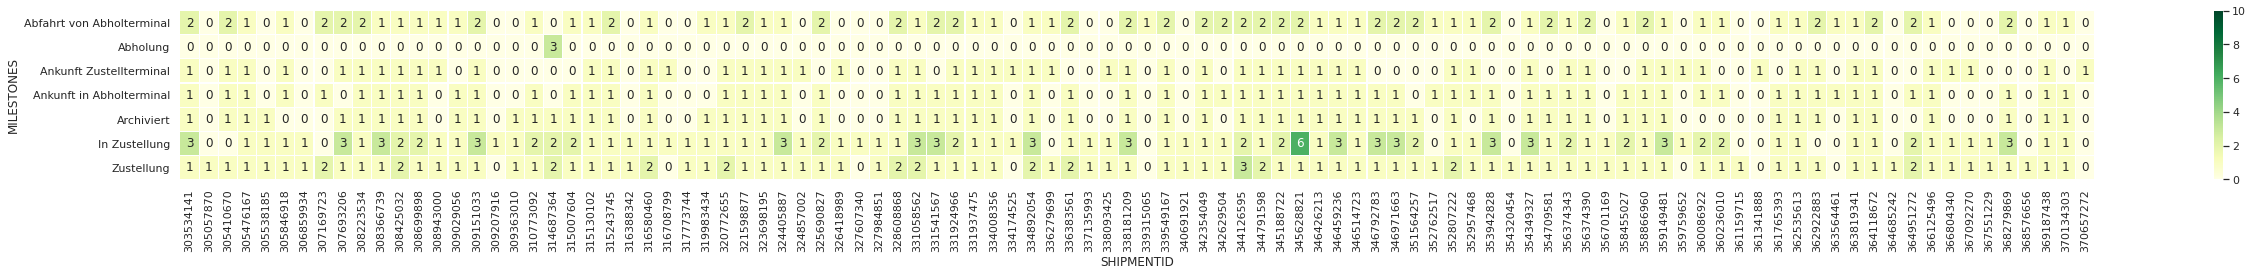

In [ ]:
plt.figure(figsize=(36,4))
_to_plot = pd.pivot_table(df_tracking_random_shipments_100_agg_by_milestones, values='reason_DE',  index=['MILESTONES'], columns='SHIPMENTID',fill_value=0)
# print(_to_plot)
ax = sns.heatmap(_to_plot, linewidths=0.1, cmap='YlGn', vmin=-0.0, vmax=10.0, annot=True) # annot=True
plt.tight_layout()
plt.show()

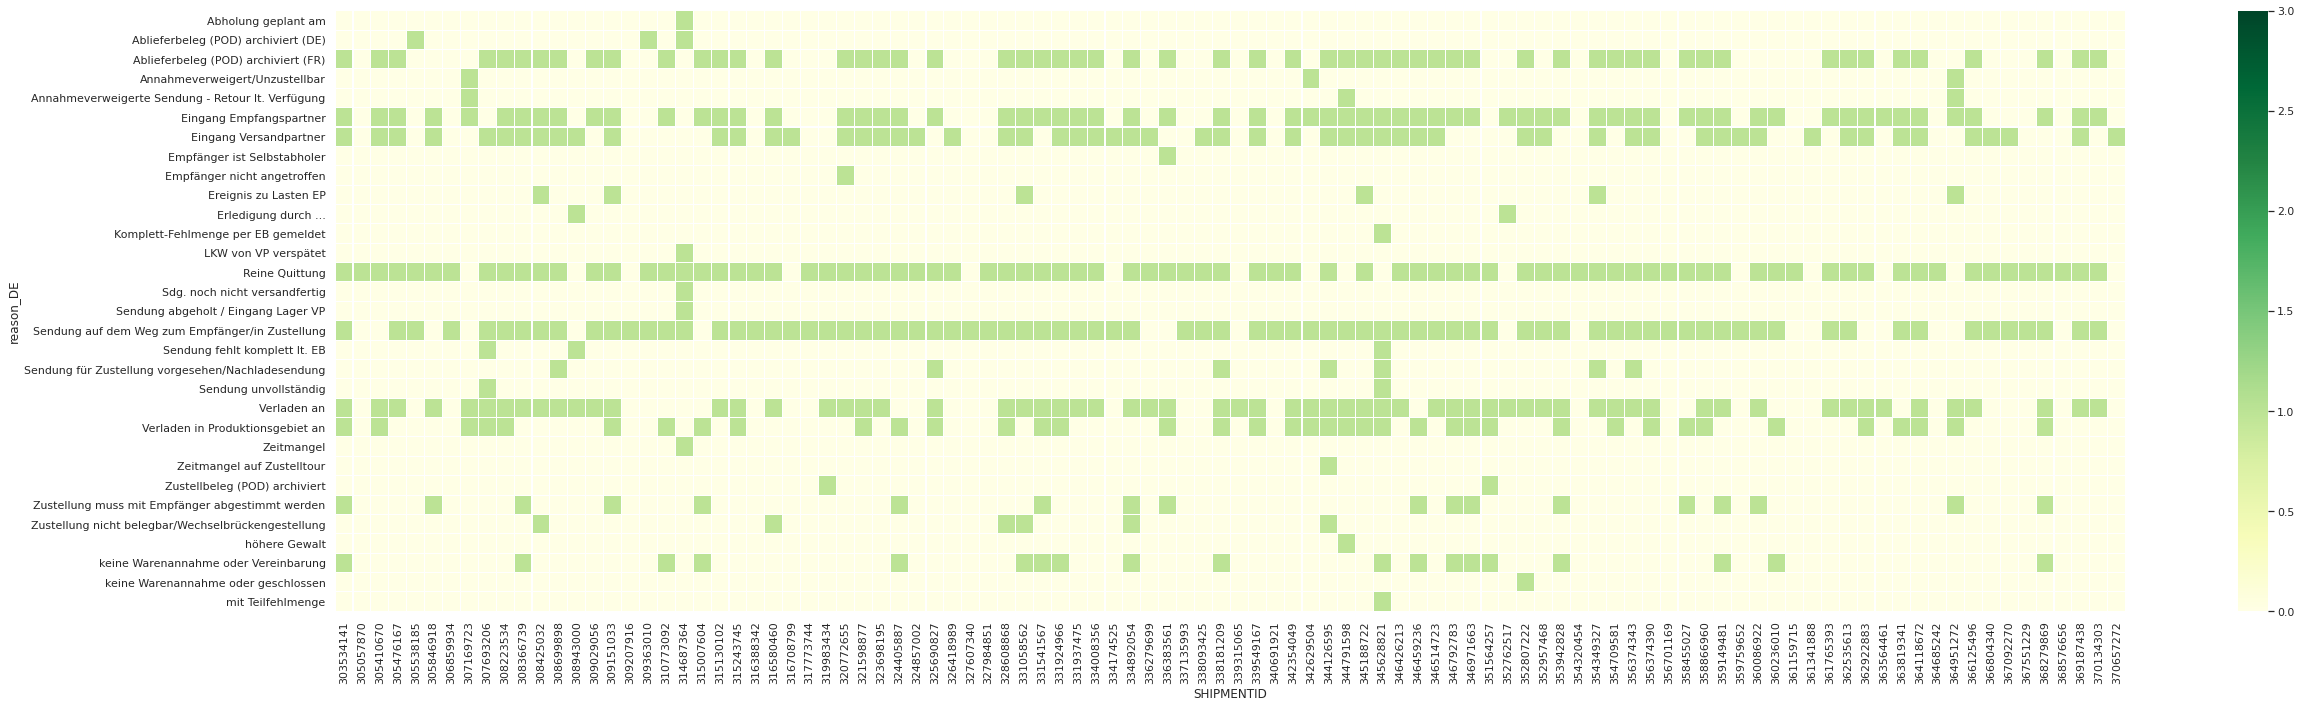

In [ ]:
plt.figure(figsize=(36,10))
_to_plot = pd.pivot_table(df_tracking_random_shipments_100_agg_by_reason, values='MILESTONES',  index=['reason_DE'], columns='SHIPMENTID',fill_value=0)
# print(_to_plot)
ax = sns.heatmap(_to_plot, linewidths=0.1, cmap='YlGn', vmin=-0.0, vmax=3.0) # annot=True
plt.tight_layout()
plt.show()

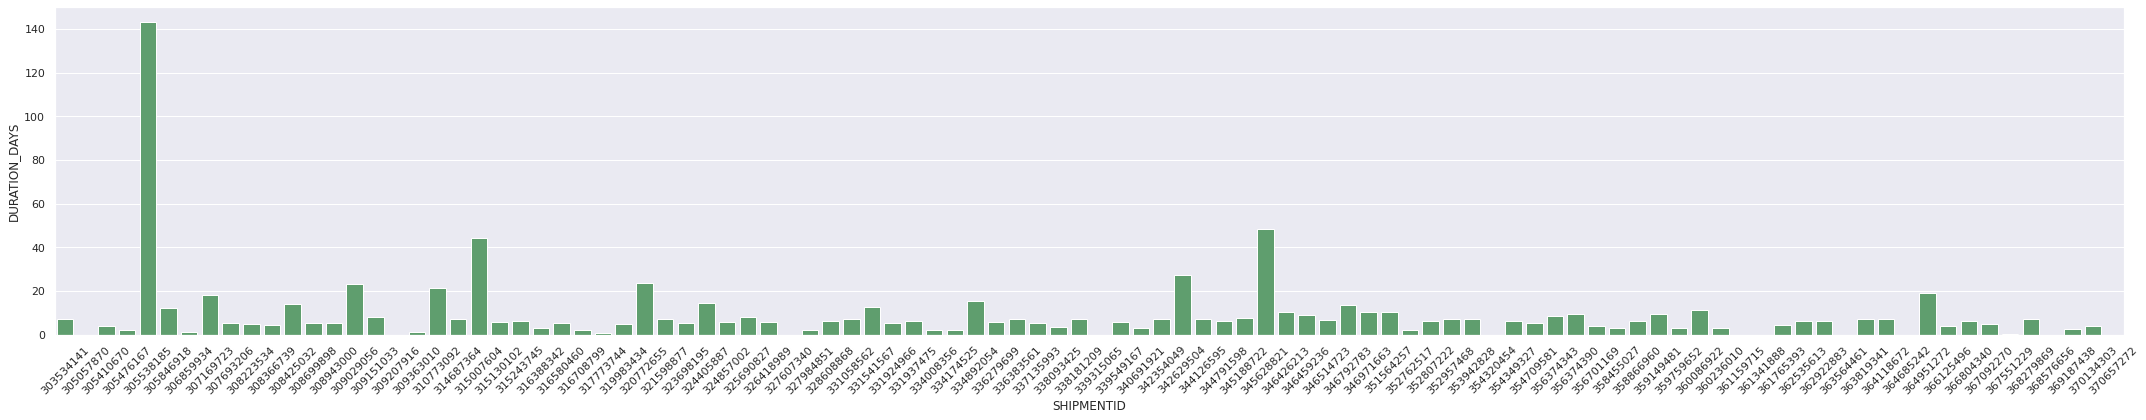

In [ ]:
# distribution of all 
import seaborn as sns
sns.set_theme()
sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(30,6))

new_df_tracking_random_shipments_100 = SHIPMENT_DURATION_BY_EVENTS[SHIPMENT_DURATION_BY_EVENTS['SHIPMENTID'].isin(random_shipments_100)].sort_values(by=['SHIPMENTID'])
new_df_tracking_random_shipments_100['DURATION_DAYS'] = new_df_tracking_random_shipments_100['DURATION'].dt.total_seconds()/(3600 * 24)
ax0 = sns.barplot(x='SHIPMENTID', y="DURATION_DAYS", data=new_df_tracking_random_shipments_100, color="g")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


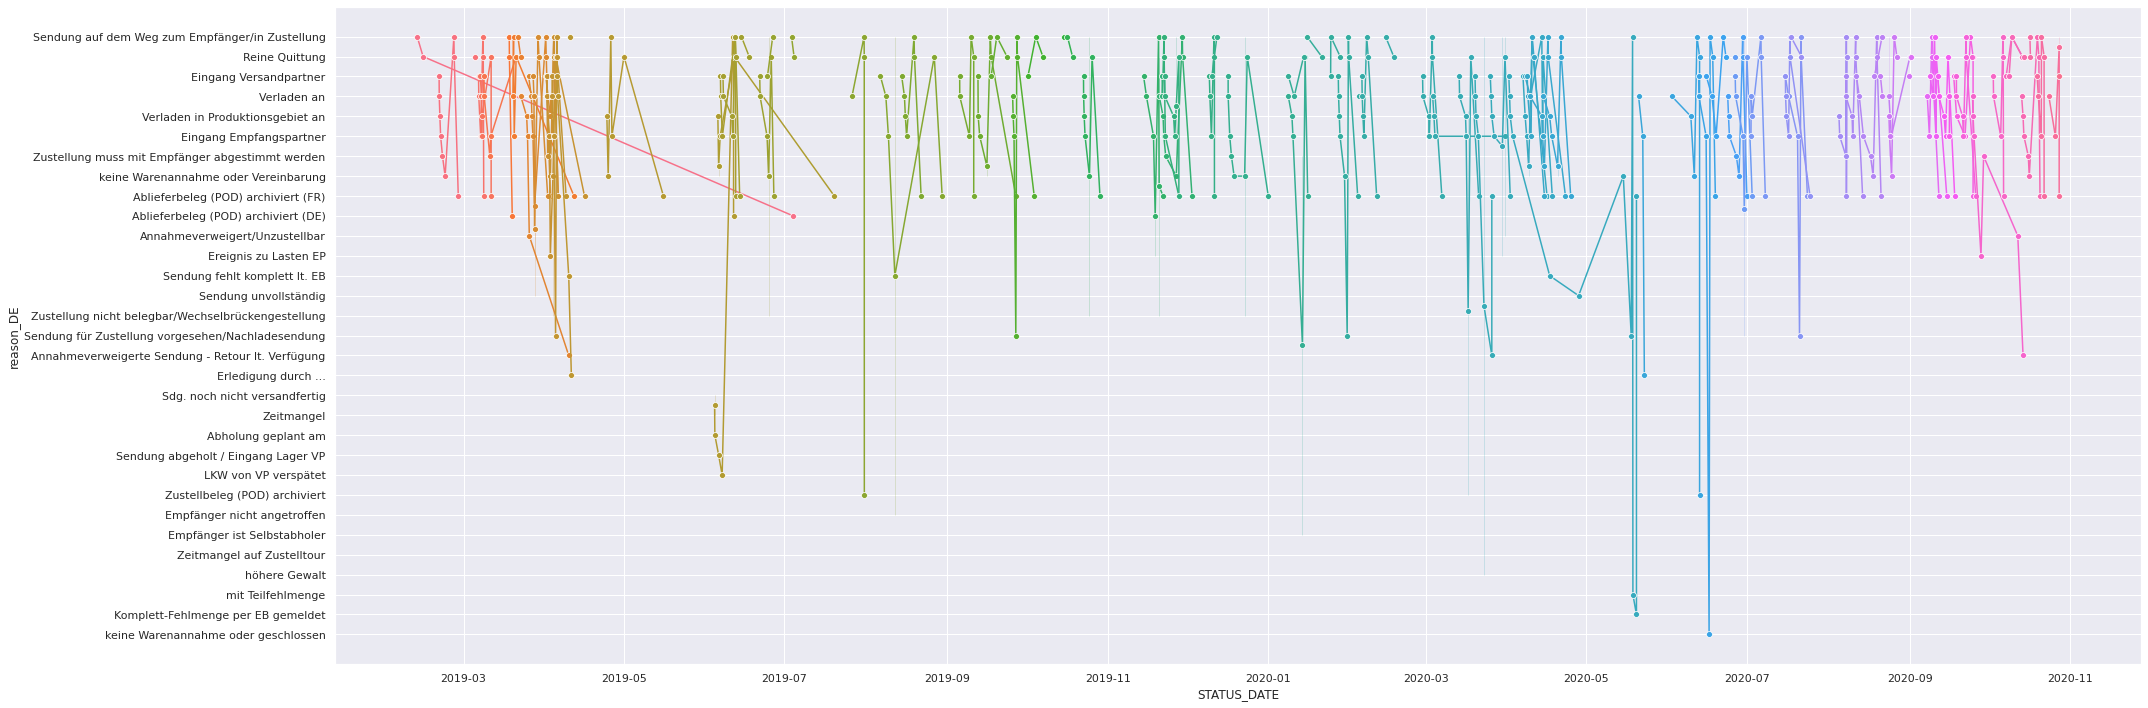

In [ ]:
# distribution of all 
import seaborn as sns

plt.figure(figsize=(30,10))
ax1 = sns.lineplot(data=df_tracking_random_shipments_100.sort_values(by=['STATUS_DATE', 'REIHENFOLGE', 'reason_DE']), x="STATUS_DATE", y="reason_DE",hue="SHIPMENTID", marker="o", sort=False, legend=False )

plt.tight_layout()
plt.show()

# Export

In [ ]:
# Export Data
# Dataframe to export
df_tracking_no_duplicate_sorted.to_json(
    "./data/results/tracking_status_processed_28_01_2021_{}_{}.json".format(0, 200000), orient='records')